In [1]:
import sodapy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Proj, transform
import pycrs

import seaborn as sns

from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, LineString, MultiLineString
from shapely.ops import linemerge

from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

from shapefile import Reader

from IPython.display import display

%matplotlib inline
sns.set()

data_url = 'data.cityofchicago.org'
app_token = '6xUrAQkGuIctuyUrTEdLZZFRY'
d_trips = 'fg6s-gzvg'
d_stats = 'aavc-b2wj'

l_lines = '8mj8-j3c4'

api = sodapy.Socrata(data_url, app_token)

In [2]:
df_stats = pd.read_csv('stations_trip_counts.csv', index_col=0)
df_stats[['num_trips_to', 'num_trips_from']] = df_stats[['num_trips_to', 'num_trips_from']].astype(float)

In [3]:
df_wd_to_counts = pd.read_csv('stations_hourly_wd_to_counts.csv', index_col=0)
df_wd_from_counts = pd.read_csv('stations_hourly_wd_from_counts.csv', index_col=0)
df_wd_counts = df_wd_to_counts + df_wd_from_counts

trips_tot = df_wd_counts.sum(axis=1)

In [4]:
filt = (trips_tot > 1000) & (trips_tot < 60000)
stats = df_stats[filt]

wd_from_counts = df_wd_from_counts[filt]
wd_to_counts = df_wd_to_counts[filt]
wd_counts = df_wd_counts[filt]

trips_tot = wd_counts.sum(axis=1)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


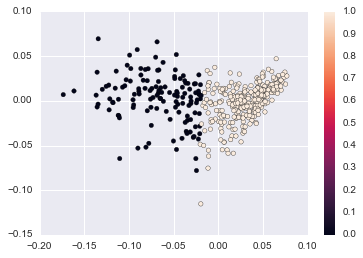

In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X = wd_to_counts

X_norm = X.div(trips_tot, axis=0)

num_to_pca = PCA(n_components=2)
y = num_to_pca.fit_transform(X_norm)

km = KMeans(n_clusters=2)
clust = km.fit_predict(y)
stats['cluster'] = pd.Series(clust).values

plt.scatter(y[:, 0], y[:, 1], c=clust)
# plt.scatter(y[:, 0], np.ones(y.shape), c=clust)
plt.colorbar()

In [7]:
# Get bounding box for Chicago

s_lat = 41.735  # 87th street
n_lat = 42.069  # Wilmette
# w_lon = -87.816  # Forest Park
w_lon = -87.916  # Forest Park
e_lon = -87.524  # State line

map = Basemap(projection='tmerc', ellps='WGS84',
              lon_0=0.5*(w_lon + e_lon),
              lat_0=0.5*(s_lat + n_lat),
              llcrnrlon=w_lon, llcrnrlat=s_lat,
              urcrnrlon=e_lon, urcrnrlat=n_lat,
              resolution='i', suppress_ticks=True)

# Read Chicago Community Areas shapefile
map.readshapefile('chi_ca/chi_ca', name='chicago',
                  drawbounds=False, color='none', zorder=2);

# map.readshapefile('chi_CTA/CTA_RailLines', name='cta',
#                   drawbounds=False, color='none', zorder=3);

# Read neighborhoods shapefile
hoods = pd.DataFrame({'poly': [Polygon(xy) for xy in map.chicago],
                      'name': [n['community'] for n in map.chicago_info]})

# Create a patch for each neighborhood
hoods['patch'] = hoods['poly']\
    .map(lambda x: PolygonPatch(x, fc='#AAAAAA',
                                ec='#000000', lw=.25, alpha=.9,
                                zorder=1))
    
# Read CTA L lines shapefile
proj4str = pycrs.loader.from_file('chi_CTA/CTA_RailLines.prj').to_proj4()

inProj = Proj(proj4str, preserve_units=True)
outProj = Proj(init='epsg:4326')

cta = Reader('chi_CTA/CTA_RailLines.shp')
l_lines = pd.DataFrame({'line': [r[5] for r in cta.records()],
                        'LineString': [LineString(zip(*transform(inProj, outProj, zip(*c.points)[0], zip(*c.points)[1]))) for c in cta.shapes()]})

blue = linemerge(MultiLineString(l_lines[l_lines['line'] == 'BL']['LineString'].tolist()))
red = linemerge(MultiLineString(l_lines[l_lines['line'] == 'RD']['LineString'].tolist()))
brn = linemerge(MultiLineString(l_lines[l_lines['line'] == 'BR']['LineString'].tolist()[4:19]))

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


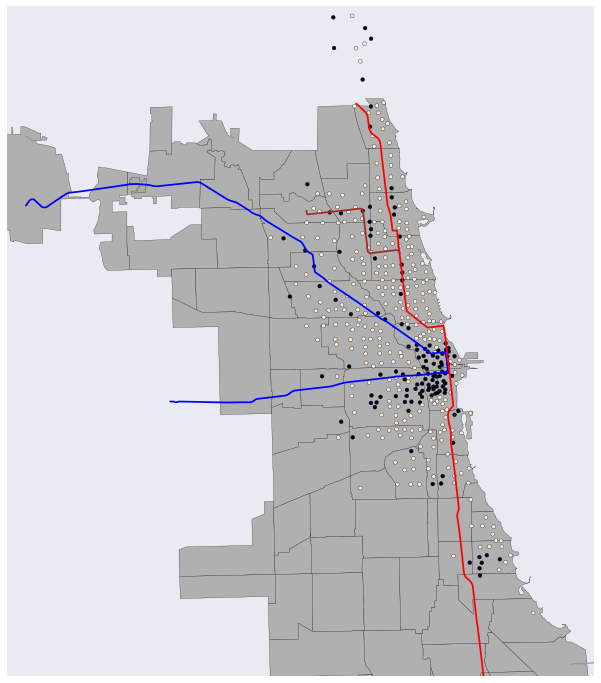

In [8]:
stats['map_point'] = [Point(map(x, y)) for x, y in zip(stats['longitude'], stats['latitude'])]

fig, ax = plt.subplots(figsize=(12, 12))

map.scatter([p.x for p in stats['map_point']],
            [p.y for p in stats['map_point']],
            c=stats['cluster'], s=15, zorder=2);

ax.add_collection(PatchCollection(hoods['patch'].values, match_original=True))

# Plot a rail line
blue_x, blue_y = blue.xy
blue_mx, blue_my = map(np.array(blue_x) + 8.21888, np.array(blue_y) + 0.255)
map.plot(blue_mx, blue_my, c='b')

red_x, red_y = red.xy
red_mx, red_my = map(np.array(red_x) + 8.21888, np.array(red_y) + 0.25)
map.plot(red_mx, red_my, c='r')

brn_x, brn_y = brn.xy
brn_mx, brn_my = map(np.array(brn_x) + 8.21888, np.array(brn_y) + 0.25)
map.plot(brn_mx, brn_my, c='brown')

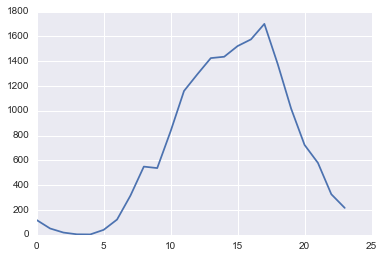

In [9]:
plt.plot(df_wd_to_counts.loc[2] + df_wd_from_counts.loc[2])